In [1]:
# Imports
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import classification_report
import pandas as pd

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


In [3]:
class ASLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_mapping = {}  

        # collect image paths
        for filename in os.listdir(root_dir):
            parts = filename.split('_')
            label = parts[0]  # extract label
            self.image_paths.append(os.path.join(root_dir, filename))
            self.labels.append(label)

        # continuous label mapping
        unique_labels = sorted(set(self.labels))
        self.label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = [self.label_mapping[label] for label in self.labels]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Ensure image is in grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


root_dir = 'new_data_50x50_split/'
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,))  # image norm
])

# create datasets
train_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'train'), transform=transform)
val_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'val'), transform=transform)
test_dataset = ASLDataset(root_dir=os.path.join(root_dir, 'test'), transform=transform)


In [4]:
# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
# CNN class - paper 1 architecture
class PaperCNN(nn.Module):
    def __init__(self, num_classes=24):
        super(PaperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.2)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.dropout3 = nn.Dropout2d(0.2)
        
        self.conv4 = nn.Conv2d(512, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.dropout4 = nn.Dropout2d(0.2)
        
        self.conv5 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.dropout5 = nn.Dropout2d(0.2)
        
        self.fc1 = nn.Linear(32 * 3 * 3, 512)
        self.dropout_fc1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # convrelu - dropout - bn
        x = self.bn1(self.dropout1(F.relu(self.conv1(x))))
#         print(f"Shape after conv1 + relu + dropout + bn1: {x.shape}")
        
        x = self.bn2(self.dropout2(F.relu(self.conv2(x))))
#         print(f"Shape after conv2 + relu + dropout + bn2: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = self.bn3(self.dropout3(F.relu(self.conv3(x))))
#         print(f"Shape after conv3 + relu + dropout + bn3: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = self.bn4(self.dropout4(F.relu(self.conv4(x))))
#         print(f"Shape after conv4 + relu + dropout + bn4: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = self.bn5(self.dropout5(F.relu(self.conv5(x))))
#         print(f"Shape after conv5 + relu + dropout + bn4: {x.shape}")
        x = self.pool(x)
#         print(f"Shape after pool: {x.shape}")
        
        x = x.view(-1, 32 * 3 * 3)  # Flatten last output
#         print(f"Shape after view: {x.shape}")
        
        x = self.dropout_fc1(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [6]:
# infer number of classes
def get_num_classes(dataset):
    unique_labels = set()
    for _, label in dataset:
        unique_labels.add(label)
    return len(unique_labels)

In [7]:
num_classes = get_num_classes(train_dataset)
print(num_classes)
model = PaperCNN(num_classes=num_classes)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)
print("Model initialized")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
print("Optimizer initialized")

# metric tracking
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=running_loss/len(train_loader))
        
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {train_accuracy}%")

    # val loop
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in val_loader:
            # move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    epoch_val_loss = running_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {val_accuracy}%")


print("Training complete")

24
Model initialized
Optimizer initialized


Epoch 1/10: 100%|████████████████| 4183/4183 [14:44<00:00,  4.73batch/s, loss=1]


Epoch 1, Loss: 1.0044551538866786, Accuracy: 68.58863256036338%
Validation Loss: 0.2277156155496221, Validation Accuracy: 93.15994979779668%


Epoch 2/10: 100%|█████████████| 4183/4183 [09:39<00:00,  7.22batch/s, loss=0.34]


Epoch 2, Loss: 0.3397586165717842, Accuracy: 89.04270260578532%
Validation Loss: 0.11886789098770306, Validation Accuracy: 96.34639520290057%


Epoch 3/10: 100%|█████████████| 4183/4183 [14:32<00:00,  4.79batch/s, loss=0.24]


Epoch 3, Loss: 0.2396361942891946, Accuracy: 92.24913339708343%
Validation Loss: 0.08568981923814448, Validation Accuracy: 97.40621949518895%


Epoch 4/10: 100%|█████████████| 4183/4183 [09:18<00:00,  7.50batch/s, loss=0.19]


Epoch 4, Loss: 0.19023102371132536, Accuracy: 93.8381544346163%
Validation Loss: 0.06691173869832767, Validation Accuracy: 97.94310416957188%


Epoch 5/10: 100%|████████████| 4183/4183 [09:13<00:00,  7.56batch/s, loss=0.161]


Epoch 5, Loss: 0.16123818081292426, Accuracy: 94.77124671288549%
Validation Loss: 0.05438187093627569, Validation Accuracy: 98.31613443034445%


Epoch 6/10: 100%|████████████| 4183/4183 [13:56<00:00,  5.00batch/s, loss=0.146]


Epoch 6, Loss: 0.14599374912763466, Accuracy: 95.25609610327515%
Validation Loss: 0.04573430876122864, Validation Accuracy: 98.56365918281969%


Epoch 7/10: 100%|████████████| 4183/4183 [13:47<00:00,  5.06batch/s, loss=0.133]


Epoch 7, Loss: 0.1331401066005624, Accuracy: 95.74542792254363%
Validation Loss: 0.043148881163253223, Validation Accuracy: 98.69962348347511%


Epoch 8/10: 100%|████████████| 4183/4183 [13:47<00:00,  5.06batch/s, loss=0.121]


Epoch 8, Loss: 0.12127961995228284, Accuracy: 96.07488644513506%
Validation Loss: 0.037584420455149356, Validation Accuracy: 98.8739366894436%


Epoch 9/10: 100%|████████████| 4183/4183 [13:51<00:00,  5.03batch/s, loss=0.111]


Epoch 9, Loss: 0.11128151949121924, Accuracy: 96.37147382261534%
Validation Loss: 0.037415183440303285, Validation Accuracy: 98.87045042532422%


Epoch 10/10: 100%|███████████| 4183/4183 [13:46<00:00,  5.06batch/s, loss=0.102]


Epoch 10, Loss: 0.10186087032289398, Accuracy: 96.73081520439875%
Validation Loss: 0.03521293664067919, Validation Accuracy: 98.92971691535351%
Training complete


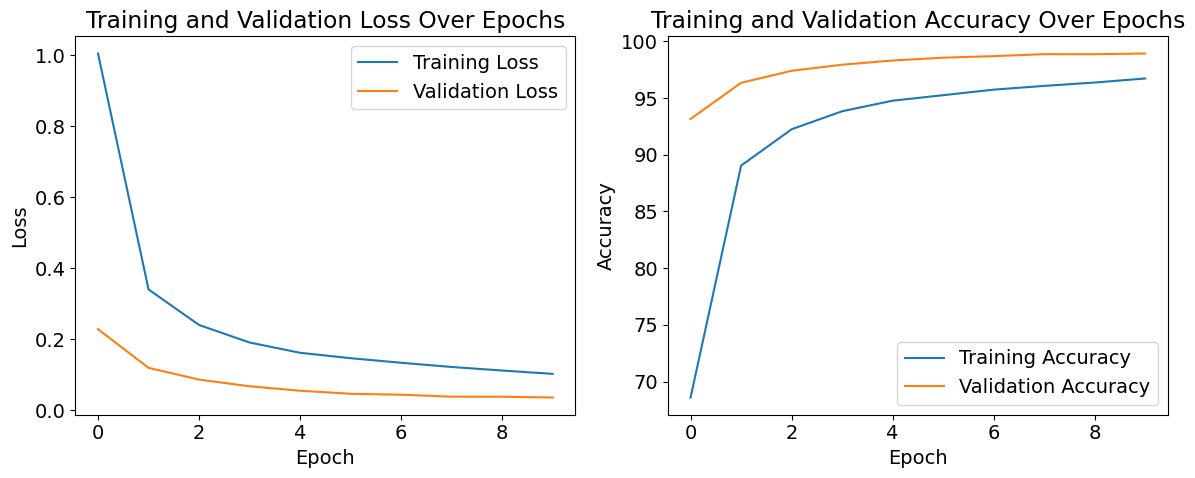

In [8]:
import matplotlib.pyplot as plt

# Set the default font size
plt.rcParams.update({'font.size': 14})

# Plot training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


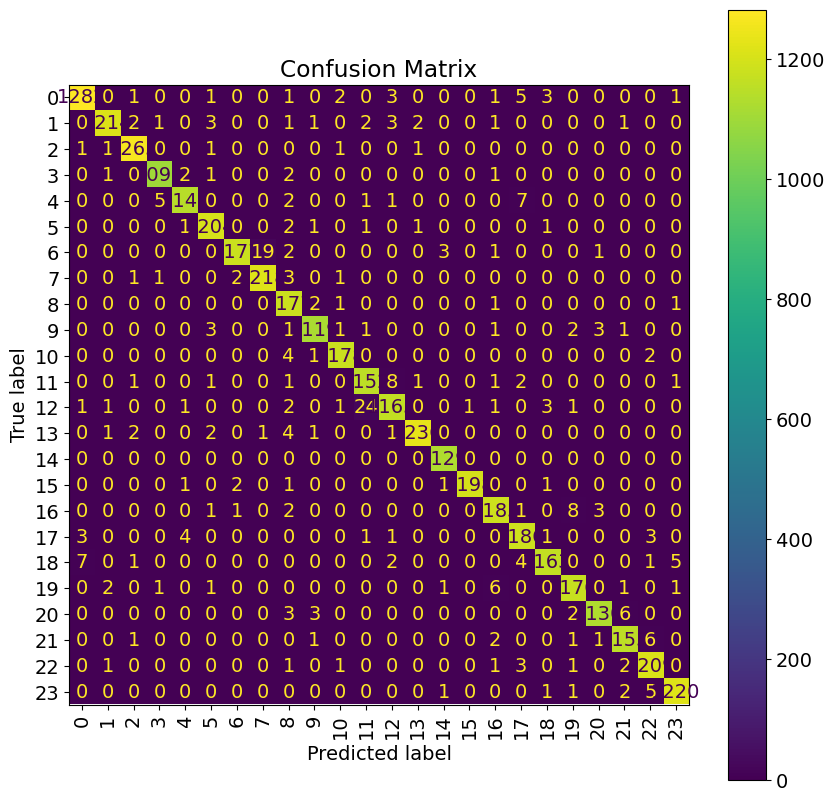

In [9]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(num_classes)])
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the size
cmd.plot(ax=ax, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Generate classification report
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)], output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Print the classification report as a table
print(df_report)

# Save the classification report to a CSV file
df_report.to_csv('classification_report.csv', index=True)

              precision    recall  f1-score       support
Class 0        0.990726  0.986154  0.988435   1300.000000
Class 1        0.994267  0.986190  0.990212   1231.000000
Class 2        0.992936  0.996063  0.994497   1270.000000
Class 3        0.992773  0.993671  0.993222   1106.000000
Class 4        0.992194  0.986207  0.989192   1160.000000
Class 5        0.988506  0.994220  0.991354   1211.000000
Class 6        0.995770  0.978387  0.987002   1203.000000
Class 7        0.983845  0.993475  0.988636   1226.000000
Class 8        0.973532  0.995770  0.984525   1182.000000
Class 9        0.991143  0.988516  0.989828   1132.000000
Class 10       0.993255  0.994093  0.993674   1185.000000
Class 11       0.974619  0.986301  0.980426   1168.000000
Class 12       0.983953  0.970025  0.976939   1201.000000
Class 13       0.995971  0.990385  0.993170   1248.000000
Class 14       0.994714  1.000000  0.997350   1129.000000
Class 15       0.999166  0.995017  0.997087   1204.000000
Class 16      

In [11]:
# Test accuracy
# Test loop
model.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        # move images and labels to device
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

epoch_test_loss = running_test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {epoch_test_loss}, Test Accuracy: {test_accuracy}%")

Test Loss: 0.03351987598006018, Test Accuracy: 99.01338725421839%
